### Regression with Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy.stats.mstats import winsorize

In [3]:
df=pd.read_csv('../appliances-energy.csv')
df.head(3)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


In [4]:
#Due to lot of zero enteries, this column is of not much use and will be ignored in rest of the model.
df.drop(columns='lights',axis=1,inplace=True)

In [5]:
df['date'] = pd.to_datetime(df['date'])
df= df.set_index('date')
df.index.name ='time'
df['date'] = df.index.date
df['day'] = df.index.day
df['month'] = df.index.month
df['hour'] = df.index.hour

In [6]:
df2=pd.concat([df.groupby(['month','day','hour']).Appliances.sum(),
           df.groupby(['month','day','hour']).mean().drop('Appliances',axis=1)],axis=1)

In [7]:
def f(x):
    x = x +273.15
    return x

In [8]:
dfk=df2.copy()
temp_list=['T1','T2','T3','T4','T6','T5','T7','T8','T9','T_out','Tdewpoint']
for i in temp_list:
    dfk[i] = dfk[i].apply(f)

In [9]:
dfkw=pd.DataFrame()
others=['RH_4','RH_6','T7']
for i in others:
    dfkw['w_%s'%i]=dfk[i]

In [10]:
#One by one, we kept winsorization low ratio because it might cause some side effects if we increase that ratio too much.
dfkw['w_Appliances']=winsorize(dfk.Appliances,(0,0.105))
dfkw['w_T1']=winsorize(dfk.T1,(0.05,0.05))
dfkw['w_RH_1']=winsorize(dfk.RH_1,(0.01,0.01))
dfkw['w_T2']=winsorize(dfk.T2,(0,0.04))
dfkw['w_RH_2']=winsorize(dfk.RH_2,(0.01,0.01))
dfkw['w_T3']=winsorize(dfk.T3,(0,0.02))
dfkw['w_T4']=winsorize(dfk.T4,(0.01,0.01))
dfkw['w_T5']=winsorize(dfk.T5,(0,0.01))
dfkw['w_RH_5']=winsorize(dfk.RH_5,(0.001,0.07))
dfkw['w_T6']=winsorize(dfk.T6,(0,0.05))
dfkw['w_RH_7']=winsorize(dfk.RH_7,(0,0.04))
dfkw['w_T_out']=winsorize(dfk.T_out,(0,0.04))
dfkw['w_Press_mm_hg']=winsorize(dfk.Press_mm_hg,(0.012,0))
dfkw['w_RH_out']=winsorize(dfk.RH_out,(0.02,0))
dfkw['w_Windspeed']=winsorize(dfk.Windspeed,(0,0.02))
dfkw['w_Visibility']=winsorize(dfk.Visibility,(0.05,0.125))
dfkw['w_RH_3']=winsorize(dfk.RH_3,(0,0.001))
dfkw['w_T8']=winsorize(dfk.T8,(0.05,0))
dfkw['w_RH_8']=winsorize(dfk.RH_8,(0,0.01))
dfkw['w_T9']=winsorize(dfk.T9,(0,0.001))
dfkw['w_RH_9']=winsorize(dfk.RH_9,(0.001,0.001))
dfkw['w_Tdewpoint']=winsorize(dfk.Tdewpoint,(0,0.001))
dfkw['w_rv1']=winsorize(dfk.rv1,(0.005,0.005))
dfkw['w_rv2']=winsorize(dfk.rv2,(0.005,0.005))

In [11]:
df3=dfkw.copy()
dflog=pd.DataFrame()
for col in df3.columns:
    dflog['log_%s'%col]=np.log(df3[col])

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(dflog)
min_max=scaler.transform(dflog)
scale_df=pd.DataFrame(min_max)
scale_df=scale_df.rename({0:'Appliances'},axis=1)

In [14]:
#Train-test split
from sklearn.model_selection import train_test_split
X = scale_df.drop('Appliances',axis=1)
y = scale_df.Appliances
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 40)

In [16]:
from sklearn.ensemble import RandomForestRegressor
rand_f=RandomForestRegressor(n_estimators=25,random_state=2)
rand_f.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

In [20]:
from sklearn.metrics import mean_squared_error as MSE
y_pred=rand_f.predict(X_test)
rmse_predict=MSE(y_test,y_pred)**(1/2)
print("RMSE value of Random Forest :{:.3f}".format(rmse_predict))

RMSE value of Random Forest :0.034


In [21]:
# We found Rmse value 0.046 when we used the Decision Tree Algorithm.

### Classification with Random Forest

In [33]:
telco=pd.read_csv('../telco_customer_churn.csv')
telco.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [34]:
telco.dropna(inplace=True)
telco=telco.drop(['customerID'],axis=1)
target=['Churn']
categorical=telco.select_dtypes(include='object').columns.tolist()
categorical=[x for x in categorical if x not in target]
numeric=telco.dtypes[telco.dtypes!=object].keys().tolist()

In [35]:
telco.Churn=telco.Churn.replace({"Yes":1, "No":0})
telco2=pd.concat([telco,pd.get_dummies(telco[categorical])],axis=1).drop(telco[categorical],axis=1)

In [36]:
X=telco2.drop('Churn',axis=1)
y=telco2.Churn

In [59]:
from sklearn.preprocessing import StandardScaler
#Instantiate the scaler
scaler=StandardScaler()
Xsc=scaler.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20, random_state=40,stratify = y)

In [60]:
from sklearn.ensemble import RandomForestClassifier
rand_clf=RandomForestClassifier(n_estimators=50, random_state=2)
rand_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [63]:
from sklearn.metrics import accuracy_score,f1_score
y_pred=rand_clf.predict(X_test)
print("Accuracy value of Random Forest:",round(accuracy_score(y_test,y_pred),2))

Accuracy value of Random Forest: 0.79


In [67]:
rf_probs=rand_clf.predict_proba(X_test)[:,1]

AUC Score: 0.8210299930248779


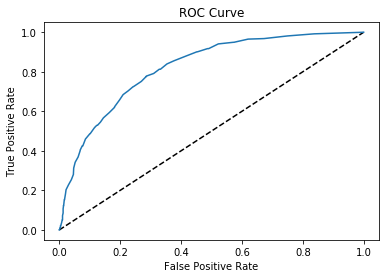

In [69]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds  = roc_curve(y_test, rf_probs)
import matplotlib.pyplot as plt
print("AUC Score:",roc_auc_score(y_test, rf_probs))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [71]:
# Also lets see confusion matrix
from sklearn.metrics import confusion_matrix,recall_score
confusion_matrix_test = confusion_matrix(y_test,y_pred)
print("Confusion Matrix (Test Data)", confusion_matrix_test, sep="\n")
print("\nF1 Score(Test):",f1_score(y_test,y_pred))

Confusion Matrix (Test Data)
[[930 105]
 [192 182]]

F1 Score(Test): 0.5506807866868381
